# Introduction

In this notebook we demonstrate the use of an **Ensemble Model**, based on Logistic Regression model, in the Information Retrieval context to make trace link recovery between Use Cases and Bug Reports.

We model our study as follows:

* Each bug report title, summary and description compose a single query.
* We use each use case content as an entire document that must be returned to the query made

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.linear_model import LogisticRegressionCV

#from utils import plots
from utils import oracle_loader as ol
from utils import jedit_dataset as jd

## Load Dataset and Preprocessing

In [2]:
trace_df = jd.read_trace_df()
artfs_desc_df = jd.read_artfs_desc_df()

use_cases_df = artfs_desc_df[artfs_desc_df.artf_description.str.contains('Use Case ID')]
bug_reports_df = artfs_desc_df[artfs_desc_df.artf_description.str.contains('Bug Number')]

corpus = use_cases_df.artf_description
query = bug_reports_df.artf_description

use_cases_names = use_cases_df.artf_name
bug_reports_names = bug_reports_df.artf_name

orc = ol.OracleLoader(use_cases_names, bug_reports_names)
orc.load(trace_df)

## Load Models Results

In [3]:
lsi_results_df = pd.read_csv('best_models_sim_matrix/lsi.csv')
lda_results_df = pd.read_csv('best_models_sim_matrix/lda.csv')
bm25_results_df = pd.read_csv('best_models_sim_matrix/bm25.csv')
wv_results_df = pd.read_csv('best_models_sim_matrix/wv.csv')

lsi_results_df.set_index('artf_name', inplace=True)
lda_results_df.set_index('artf_name', inplace=True)
bm25_results_df.set_index('artf_name', inplace=True)
wv_results_df.set_index('artf_name', inplace=True)

### Tranform Results Matrices to Vectors

In [4]:
def transform_sim_matrix_to_sim_vec(sim_matrix_df, model_name):
    sim_vec_df = pd.DataFrame(columns=[model_name])
    for col in sim_matrix_df.columns:
        for idx, row in sim_matrix_df.iterrows():
            artfs_names = '{}_{}'.format(idx, col)
            sim_vec_df.at[artfs_names, model_name] = row[col]
    return sim_vec_df

sim_vec_lsi = transform_sim_matrix_to_sim_vec(lsi_results_df, 'lsi')
sim_vec_lda = transform_sim_matrix_to_sim_vec(lda_results_df, 'lda')
sim_vec_bm25 = transform_sim_matrix_to_sim_vec(bm25_results_df, 'bm25')
sim_vec_wv = transform_sim_matrix_to_sim_vec(wv_results_df, 'wordvector')

### Transform Vectors to DataFrame

In [5]:
ensemble_input_df = pd.DataFrame(columns=['ens_pred'], index=sim_vec_lsi.index)

out_df = pd.merge(ensemble_input_df, sim_vec_lsi, left_index=True, right_index=True)
out_df = pd.merge(out_df, sim_vec_lda, left_index=True, right_index=True)
out_df = pd.merge(out_df, sim_vec_bm25, left_index=True, right_index=True)
out_df = pd.merge(out_df, sim_vec_wv, left_index=True, right_index=True)

new_order = [1,2,3,4,0]
out_df = out_df[out_df.columns[new_order]]

ensemble_input_df = out_df.copy()
ensemble_input_df.head()

,lsi,lda,bm25,wv,ens_pred
UC_003_TRG_BR_4020_SRC,0.361541,0.988073,7.08953,0.922483,NaN
UC_007_TRG_BR_4020_SRC,0.46841,0.9881,9.83479,0.878566,NaN
UC_010_TRG_BR_4020_SRC,0.690679,0.154894,16.8103,0.906589,NaN
UC_002_TRG_BR_4020_SRC,0.897997,0.988134,5.33088,0.923327,NaN
UC_006_TRG_BR_4020_SRC,0.911746,0.988105,5.08051,0.924785,NaN


### Insert Oracle Data

In [6]:
orc_vec_df = transform_sim_matrix_to_sim_vec(orc.oracle, 'oracle')

ensemble_input_df = pd.merge(ensemble_input_df, orc_vec_df, left_index=True, right_index=True)

new_order = [0,1,2,3,5,4]
ensemble_input_df = ensemble_input_df[ensemble_input_df.columns[new_order]]

ensemble_input_df.head()

,lsi,lda,bm25,wv,oracle,ens_pred
UC_003_TRG_BR_4020_SRC,0.361541,0.988073,7.08953,0.922483,0.0,NaN
UC_007_TRG_BR_4020_SRC,0.46841,0.9881,9.83479,0.878566,0.0,NaN
UC_010_TRG_BR_4020_SRC,0.690679,0.154894,16.8103,0.906589,0.0,NaN
UC_002_TRG_BR_4020_SRC,0.897997,0.988134,5.33088,0.923327,0.0,NaN
UC_006_TRG_BR_4020_SRC,0.911746,0.988105,5.08051,0.924785,1.0,NaN


### Split Data on Train and Test

In [7]:
X = ensemble_input_df[['lsi','lda','bm25','wv']]
y = ensemble_input_df['oracle']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

### Calculate Scores Function

In [8]:
def calculate_scores(model):
    model = model.fit(X_train, y_train)
    dd = pd.DataFrame(index=X_test.index, columns=['orc', 'pred'])
    dd['orc'] = np.array(y_test)
    dd['pred'] = model.predict(X_test)
    
    precision = precision_score(y_true=dd['orc'], y_pred=dd['pred'])
    recall = recall_score(y_true=dd['orc'], y_pred=dd['pred'])
    fscore = f1_score(y_true=dd['orc'], y_pred=dd['pred'])
    
    return [precision, recall, fscore]

### Logistic Regressor

In [9]:
model = LogisticRegressionCV(cv=3, scoring='recall')
p,r,f = calculate_scores(model)

print('Recall: {:2.3}'.format(r))
print('Precision: {:2.3}'.format(p))
print('F-Score {:2.3}'.format(f))

Recall: 0.444
Precision: 0.8
F-Score 0.571


In [10]:
model.coef_

array([[10.4452324 , 21.1194777 ,  0.08605471, -4.63107383]])

In [13]:
#plots.plot_data_and_predictions_3d_in_2d(X_test, y_test, is_binary=True, nn=None, cmap='bwr')
from mglearn.plot_2d_separator import *
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=n_neighbors).fit(X_train, y_train)
plot_2d_separator(clf, X_test, fill=True, eps=0.5, ax=ax, alpha=.4)
discrete_scatter(X_test[:,0], X_test[:,1], y_test)
ax.set_title("{} neighbor(s)".format(n_neighbors))
ax.set_xlabel("feature 0")
ax.set_ylabel("feature 1")
axes[0].legend(loc=3)

NameError: name 'n_neighbors' is not defined

### KNN

/home/guilherme/anaconda3/envs/trace-link-recovery-study/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys


ValueError: query data dimension must match training data dimension

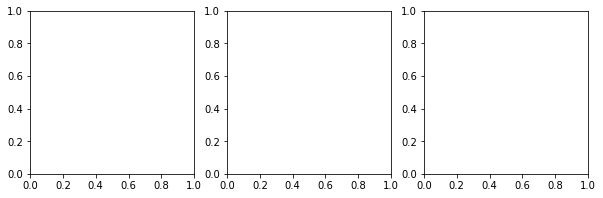

In [23]:
from sklearn.neighbors import KNeighborsClassifier
from mglearn.plot_2d_separator import *

fig, axes = plt.subplots(1, 3, figsize=(10, 3))
for n_neighbors, ax in zip([1, 3, 9], axes):
    clf = KNeighborsClassifier(n_neighbors=n_neighbors).fit(X_test, y_test)
    plot_2d_separator(clf, X_test.as_matrix(), fill=True, eps=0.5, ax=ax, alpha=.4)
    discrete_scatter(X_test.iloc[:, 0], X_test.iloc[:, 1], y_test, ax=ax)
    ax.set_title("{} neighbor(s)".format(n_neighbors))
    ax.set_xlabel("feature 0")
    ax.set_ylabel("feature 1")
axes[0].legend(loc=3)

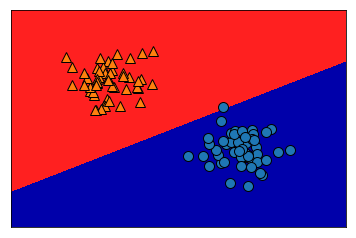

In [20]:
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression
from mglearn.plot_2d_separator import *

X, y = make_blobs(centers=2)
clf = LogisticRegression().fit(X, y)
plot_2d_separator(clf, X, fill=True)
discrete_scatter(X[:, 0], X[:, 1], y)
plt.show()